Calculating density using gsw toolbox and matlab-python wrappers.

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot

from salishsea_tools import nc_tools, viz_tools
from salishsea_tools import gsw_calls

import xarray as xr

In [2]:
# The same bathymetry was used for Run01 and Run02
bathyR_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/realistic/real_bathy_02.nc')
bathyR = bathyR_file['Bathymetry']

# Run02 uses an improved bathymetry - wider and more accurate canyon axis depth profile
bathyI_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_05.nc')
bathyI = bathyI_file['Bathymetry']

# The same latitudes are used for Run01 and Run02
coord_lats = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/coordinates/NEMO_files/coords_02.nc')['nav_lat'][:]

# The T, U, V results are loaded along with the tmask used for masking.
path = '/ocean/imachuca/Canyons/results_mackenzie/idealized/depth_levels/' 
gridT = xr.open_dataset(path+'/GYRE_1h_20170101_20170120_grid_T.nc')
gridU = xr.open_dataset(path+'/GYRE_1h_20170101_20170120_grid_U.nc')
gridV = xr.open_dataset(path+'/GYRE_1h_20170101_20170120_grid_V.nc')
gridW = xr.open_dataset(path+'/GYRE_1h_20170101_20170120_grid_W.nc')
mmask = xr.open_dataset(path+'/mesh_mask.nc')

#gridI, lonI, latI, temI, salI, sshI, UI, VI, WI, tmaskI = functions_plot.load_model_output(pathI, cfg)
#depth_levelsI1 = gridI1['deptht'][:]

In [3]:
sal = np.asfarray(gridT['vosaline'])
tem = np.asfarray(gridT['votemper'])
ssh = np.asfarray(gridT['sossheig'])
depth_levels = np.asfarray(gridT['deptht'])
tmask = np.asfarray(mmask['tmask'])
nav_lat = np.asfarray(gridT['nav_lat'])

In [8]:
depth_levels

array([    2.00083542,     6.00963593,    10.03525066,    14.09361267,
          18.2157402 ,    22.4620018 ,    26.94980431,    31.90716362,
          37.77567673,    45.40602875,    56.42008591,    73.84886169,
         103.14533234,   153.44302368,   238.15907288,   372.82843018,
         568.67419434,   825.69628906,  1132.67175293,  1474.06555176])

In [4]:
def gsw_pressure_arguments(coord_lats, depth_levels, y_transect):
    ''' The main purpose of this function is to reshape
    and tile the (m,) depth array and the (n,) coordinate
    slice so that they can both be (m,n) in order to find
    a (m,n) pressure field.
    '''
    depths = depth_levels.reshape(-1,1)
    depths_neg = depths * -1
    latitudes = coord_lats[y_transect,:]
    
    len_depths = len(depths)
    len_lats = len(latitudes)
    
    z = np.tile(depths_neg, (1, len_lats))
    lat = np.tile(latitudes, (len_depths, 1))
    return z, lat

# ------------------------------------------------------------------------------------------

def gsw_calculate_density(coord_lats, depth_levels, y_transect, time_ind, salx, temx, tmask):
    ''' This function uses the z and lat calculated in the previous function to calculated
    pressure. This pressure is used alongside salinity and temperature to calculate
    density profiles. Even thought SA and CT are masked arrays (and pressure is not), the
    array for rho is unmasked. tmask is used to mask it, and this follows the same procedure
    as the orginal masking done for SA and CT.
    '''
    z, lat = gsw_pressure_arguments(coord_lats, depth_levels, y_transect)
    p = gsw_calls.generic_gsw_caller('gsw_p_from_z.m', [z,lat], matlab_gsw_dir='/ocean/rich/home/matlab/gsw3')

    SA = salx[time_ind, :, y_transect, :]
    CT = temx[time_ind, :, y_transect, :]

    rho = gsw_calls.generic_gsw_caller('gsw_rho_CT_exact.m', [SA,CT,p], matlab_gsw_dir='/ocean/rich/home/matlab/gsw3')
    
    tmask_rho = tmask[time_ind, : ,y_transect, :]   
    rho_masked = np.ma.array(rho, mask=tmask_rho)
        
    return rho_masked

In [5]:
def plot_isopycnal_stories(gridTs, sals, tems, tmasks, xlims, y_transects, time_inds, coord_lats, depth_levels):
    '''This function plots vertical density profiles at different times (rows) for
    the idealized and realistic canyons (columns). It takes in the y index that 
    outlines the vertical slice. It also takes in the latitudes and depth necessary
    to calculate the pressure calculated inside the density function.
    '''
    x_inds = np.arange(sals[0].shape[-1])
    fig, ax = plt.subplots(len(time_inds), len(sals), figsize=(18, len(time_inds)*5))
    cmap = cm.Spectral
    levels = np.linspace(1026, 1029, 7)
    for gridT, sal, tem, tmask, xlim, y_transect, n in zip(gridTs, sals, tems, tmasks, xlims, y_transects, 
                                                           np.arange(len(sals))):
        for time_ind, i in zip(time_inds, np.arange(len(time_inds))):
            rho = gsw_calculate_density(coord_lats, depth_levels, y_transect, time_ind, sal, tem, tmask)
            p = ax[i,n].pcolormesh(x_inds, depth_levels, rho, cmap = cmap, vmin = 1020, vmax = 1030)
            c = ax[i,n].contour(x_inds, depth_levels, rho, levels = levels, colors='k', linewidths=1.5)
            ax[i,n].set_ylim([550,0])
            ax[i,n].set_xlim(xlim)
            timestamp = nc_tools.timestamp(gridT,time_ind).format('MMM DD HH:mm')
            #ax[i,n].set_title(timestamp)
            ax[i,n].set_title('Day ' + str(i+1), fontsize=16)
            fig.colorbar(p, ax=ax[i,n])
            ax[i,n].set_axis_bgcolor('wheat')
    return fig

In [6]:
dep = -1 * depth_levels
lat = np.ones(1) * np.mean(nav_lat)
p = gsw_calls.generic_gsw_caller('gsw_p_from_z.m', [dep, lat], matlab_gsw_dir='/ocean/rich/home/matlab/gsw3')

ps = np.zeros([20,237])
for i in range(237):
    ps[:,i] = p

y_transect = 55

tmask_rho = 1-tmask[0, : ,y_transect, :]  

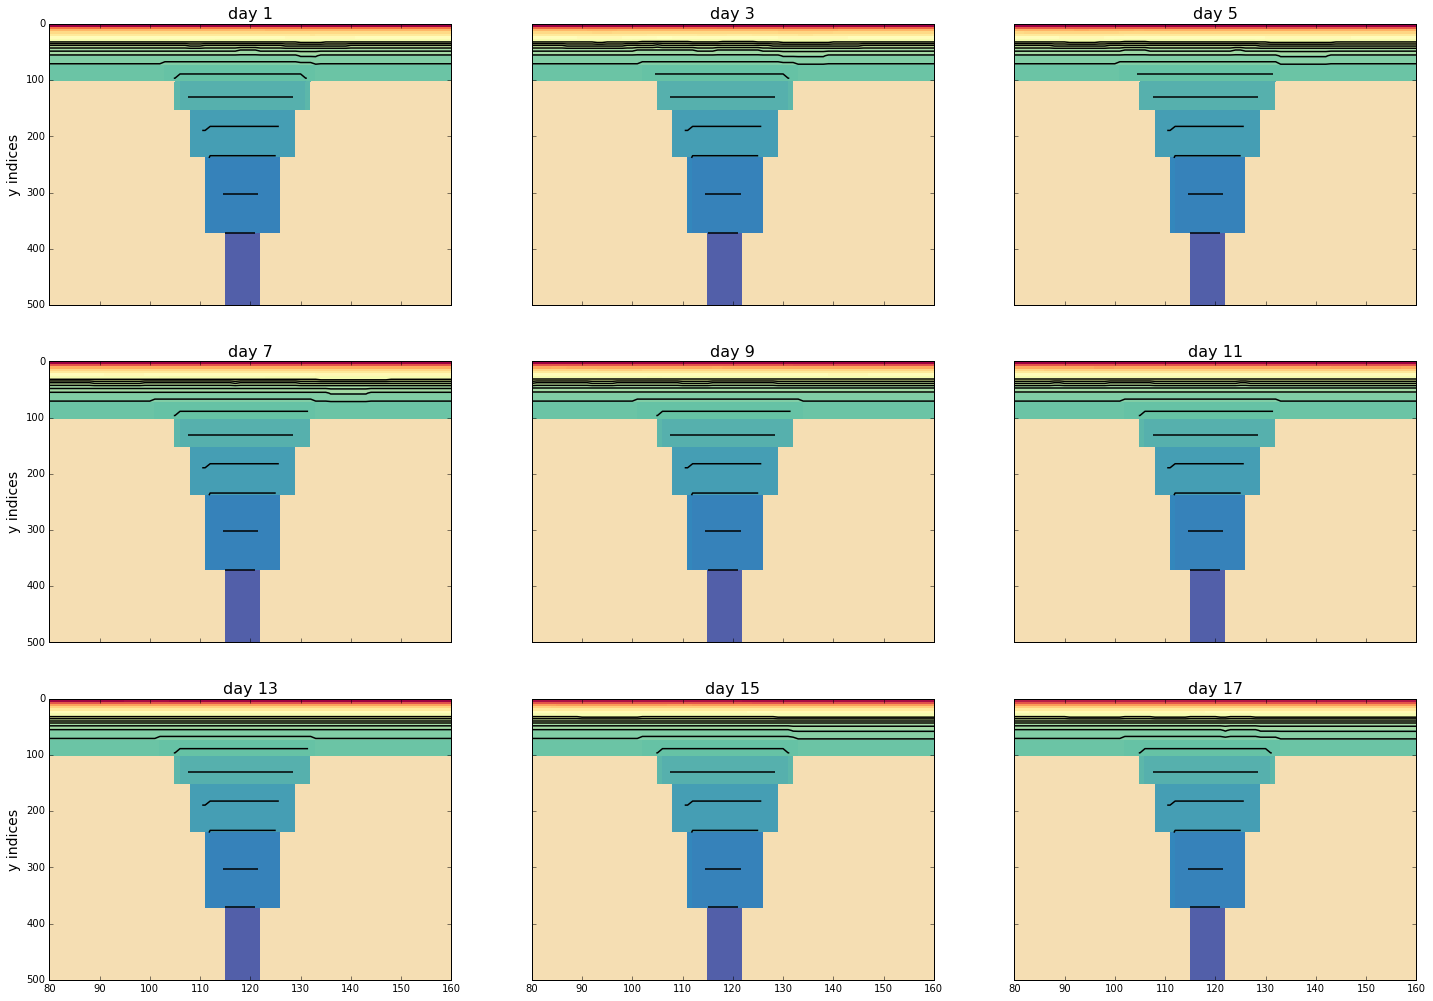

In [12]:
fig, ax = plt.subplots(3,3,figsize=(20, 14), sharex=True, sharey=True)
ax = ax.flatten()
time_inds = np.arange(1,18,2)*24
x_inds = np.arange(sal[0].shape[-1])
cmap = cm.Spectral
cmap.set_bad('wheat')
levels = np.linspace(1026, 1030, 14)


for n, time_ind in zip(np.arange(12), time_inds):
    SA = sal[time_ind, :, y_transect, :]
    CT = tem[time_ind, :, y_transect, :]
    rho0 = gsw_calls.generic_gsw_caller('gsw_rho_CT_exact.m', [SA, CT, ps], matlab_gsw_dir='/ocean/rich/home/matlab/gsw3')
    rho = np.ma.array(rho0, mask=tmask_rho)
    p = ax[n].pcolormesh(x_inds, depth_levels, rho, cmap = cmap, vmin = 1020, vmax = 1030)
    c = ax[n].contour(x_inds, depth_levels, rho, levels = levels, colors='k', linewidths=1.5)
    ax[n].set_ylim([500,0])
    ax[n].set_xlim([80,160])
    if n==0 or n==3 or n==6 or n==9:
        ax[n].set_ylabel('y indices', fontsize=14)
    if n==9 or n==10 or n==11:
        ax[n].set_xlabel('x indices', fontsize=14)
    ax[n].set_title('day '+str(int(time_ind/24)), fontsize=16)
fig.tight_layout()
fig.subplots_adjust(wspace=0.2, hspace=0.2)
plt.savefig('isopycnals.png')